Copyright (c) Microsoft Corporation. All rights reserved.

Licensed under the MIT License.

# CIFAR 10 Classification using Neural networks

##### Training a fully connected network on images and improving its classification performance.

## Table of Contents:

* [Introduction](#intro)
* [Setup](#setup)
    * [Import libraries](#lib)
    * [Configure the Workspace](#ws)
    * [Create the Experiment](#exp)
    * [Utilize the Compute Resources](#compute)
    * [Upload Dataset](#dataset)
* [Train a baseline model](#train)
* [Perform Automated Hyperparameter Tuning](#hyper)
* [Results](#results)
    


##  Introduction <a class="anchor" id="intro"></a> 

CIFAR 10 is a popular image classification dataset. It provides labeled images across different classes. The challenge is to correctly classify them in their respective classes. More information about the dataset can be found at their website -  https://www.cs.toronto.edu/~kriz/cifar.html

Neural networks are the state of the art in most of the computer vision challenges. In this tutorial, we present detailed steps to create a simple network for the classification task. 

The entire notebook has been created in Python. 


## Setup <a class="anchor" id="setup"></a>

We walk through the sequence of steps to put everything in place for our task. Further details about each step of the process can be found here - https://docs.microsoft.com/en-us/azure/machine-learning/service/

### Import the required libraries <a class="anchor" id="lib"></a>

We start by importing some python libraries for performing the classification task. Numpy provides support for performing scientific computation. Matplotlib is used to display the plots created during the task. 

Apart from them, we also import the libraries provided by Azure Machine learning. The core library from AzureML helps us lay the foundations for carrying out the task on the Azure platform. We import *Workspace* in the below step and display the Azure ML SDK version installed on our machine.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

import azureml.core
from azureml.core import Workspace

# check core SDK version number
print("Azure ML SDK Version: ", azureml.core.VERSION)

Azure ML SDK Version:  1.0.10


### Import Pytorch libraries provided with the Azure platform

In this tutorial, we will create a script using Pytorch. Azure Machine learning platform supports running pytorch scripts. To do the same, we import the corresponding module from the Deep Neural Network library provided by Azure.

In [2]:
from azureml.train.dnn import PyTorch

### Configure the workspace <a class="anchor" id="ws"></a>

Once we have all the libraries with us, the first step we take is to load the workspace where our actual experiment will happen. A workspace is always associated with an Azure subscription. This workspace provides us with all the tools that we need to complete machine learning tasks. 

In this tutorial, it is assumed that the workspace has already been setup before. We load the workspace details from the locally saved configuration file. We then print the details here just to make sure that everything is in order. 

In [3]:
ws = Workspace.from_config()
print(ws.name, ws.location, ws.resource_group, ws.location, sep = '\t')


Found the config file in: /home/shanuv/Documents/696/aml_config/config.json
AmherstWorkspace	eastus2	AmherstRG	eastus2


### Create the experiment <a class="anchor" id="exp"></a>

An experiment is exactly what is stands for. In performing a task, we will need to perform several experiments to get to the best machine learning model. In doing so, we will be playing with parameters to perform several *runs* of the experiment. 

Similarly, we create an experiment here which is used to perform different *runs*. The experiment is created in the workspace we configured. We provide a suitable name to store the experiment. This name is visible in the azure portal along with other required details. These two are provided as arguments to the Experiment class which is again imported from the AzureML core library. 

In [4]:
experiment_name = 'cifar10-classification'

from azureml.core import Experiment
exp = Experiment(workspace=ws, name=experiment_name)

### Utilize the workspace compute resources <a class="anchor" id="compute"></a>

Once we are ready to perform an experiment, we need computational resources. We use one of the clusters provided with the subscription to run the experiment. 

In the snippet below, we configure and utilize the cpucluster for this experiment. After importing the compute libraries, we choose a name for the cluster. We also provide the method to create the cluster in case one is not available.

In [ ]:
from azureml.core.compute import AmlCompute
from azureml.core.compute import ComputeTarget
import os

# choose a name for your cluster
compute_name = os.environ.get("AML_COMPUTE_CLUSTER_NAME", "cpucluster")
compute_min_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MIN_NODES", 0)
compute_max_nodes = os.environ.get("AML_COMPUTE_CLUSTER_MAX_NODES", 4)

# This example uses CPU VM. For using GPU VM, set SKU to STANDARD_NC6/STANDARD_D2_V2
vm_size = os.environ.get("AML_COMPUTE_CLUSTER_STANDARD_SKU", "STANDARD_NC6")

compute_target = ws.compute_targets[compute_name]

### Upload the dataset from your local folder to the Azure datastore <a class="anchor" id="dataset"></a>

The next step is to have the data ready to feed to the model which will be created. The workspace provides a default datastore where we can upload our dataset. We print the details of the default datastore to cross-check the same. Once we are ready, we upload the dataset from our local directory to the cloud datastore. 

In the upload command, we specify the following - 

* src_dir - Path to the local directory where the dataset is kept
* target_path - Location on the datastore relative to the root of the datastore
* overwrite - Flag to replace the existing data
* show_progress - Time remaining in the upload process

The upload step took ~3 mins for the CIFAR10 dataset for us.

In [6]:
ds = ws.get_default_datastore()
print(ds.datastore_type, ds.account_name, ds.container_name)

#ds.upload(src_dir='../682/assignment2/cs682/datasets', target_path='cifar10', overwrite=True, show_progress=True)

AzureBlob amherstwstorageinnganzr azureml-blobstore-fe92660d-c6c1-4086-b2f7-71f9c508e6c7


## Train a baseline model <a class="anchor" id="train"></a>

Now that we have the dataset and the compute resources associated with our experiment, we need to perform the training step. For the training step, we run the script using an Estimator class. This class makes it convenient for us to connect everything that we have setup till now. The estimator initializes the code written by us on the compute target and streamlines the dataset loading process for the training step. 

### Initialize the Estimator

In the below cell, we initialize a dictionary to provide the command line parameters to our training script. The *script_params* dictionary contains the argument pointing it to the datastore on the workspace where our dataset was uploaded previously. 

We then use the pytorch estimator imported earlier in the notebook. These are the parameters accepted by the estimator - 

* source_directory - The local directory which contains the training script 
* script_params - Dictionary containing the command line arguments for the training script
* compute_target - The compute resources provided along with the subscription to utilize for the experiment
* entry_script - The script which starts the training process
* use_gpu - Flag indicating whether GPU resources are to be used during the training

### Training Script description

The training script utilizes the *data_folder* to load the CIFAR dataset. Once the train-val-test splits are loaded, data is transformed within the script to normalize the values. The script then, creates the neural net model, initializes the optimizer and starts the training process. In every epoch, the script also logs the validation set accuracy on the Azure portal. 

At a later stage, two other parameters. *learning_rate* and *hidden_size* come into picture. These are the learning rate used by the SGD optimizer and the total neurons in the hidden layer of the two layer network.  

In [7]:
script_params = {
    '--data-folder': ds.as_mount()
}

pt_est = PyTorch(source_directory='./your_code',
                 script_params=script_params,
                 compute_target=compute_target,
                 entry_script='2layerfcnet.py',
                 use_gpu=True)

### Submit the Experiment

With the initialization of the estimator, we are all set to run the experiment at hand. We submit the same with the estimator created in the previous step. 

This starts off the sequence of events at the end of which we have a model with some results to show. We can close everything off and depending on the complexity of the model go for a jog or decide to call it a day. It takes ~10 mins for the behind-the-curtains setup to complete after which we have our task up and running.

In [11]:
run = exp.submit(pt_est)

### Visualizing the submission

However, we also have the option to track what is happening during the course of the experiment. To do that, we again import some libraries and with the submitted experiment's name, we extract its details using the below command - 

In [ ]:
from azureml.widgets import RunDetails
RunDetails(run).show()

We get the snapshot as shown here once the training is completed. While the training is being done, one can check the status of the *run* as well. All the updates related to the process happening are displayed here. Alternatively, one can check the portal to view the metrics that have been logged during the training. More steps on how to log parameters are available here - https://docs.microsoft.com/en-us/azure/machine-learning/service/how-to-track-experiments

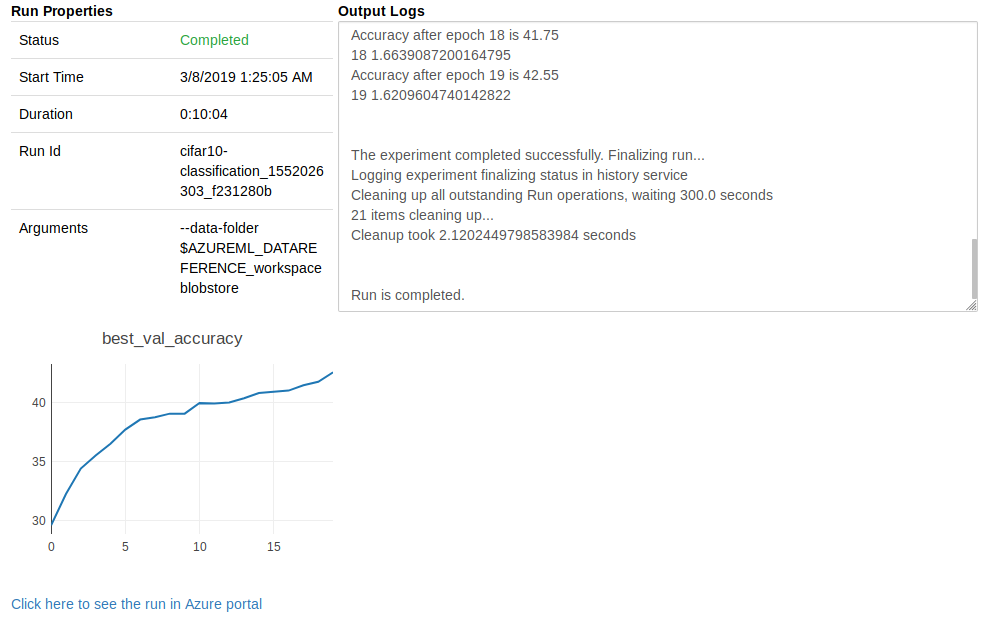

## Moving forward - Automated Hyperparameter search <a class="anchor" id="hyper"></a>

Our basic model consisting of fully connected layers achieves an accuracy of ~42%. However, is that the best that can be achieved with this model? Hmmmm.....

In the training script, we fixed the learning rate arbitrarily. We could instead choose to explore the effect of changing this hyperparameter to our accuracy. 

We can use the neat hyperparameter search feature provided along with the Azure platform to perform this sub-task. The main advantage of doing this is that we can run several training jobs parallely to select the best hyperparameter for the dataset. We will provide the bounds over which this search takes place along with the parameter sampling policy. 

In the current tutorial, we perform random sampling from a uniform distribution over the min and max values for the learning rate. The required classes are imported from the azureml.train.hyperdrive library and initialized accordingly. Here, uniform is the uniform distribution over the range that has been specified as its arguments. We use the RandomParameterSampling class to initialize the sampling strategy.

In [8]:
from azureml.train.hyperdrive import RandomParameterSampling,normal,uniform,choice
param_sampling = RandomParameterSampling( {
                    "learning_rate": uniform(0.0001, 0.1),
}
)

### Configuring the hyperparameter sweep

Azure platform will run several parallel jobs for the purpose of extracing the most suitable hyperparameters. We can speed this up by terminating some runs which perform poorly. This helps free up resources where waiting jobs can be run. This in turn reduces the time taken to get the best *learning_rate* parameter. 

We demonstrate the bandit policy as the termination criteria here. More information regarding termination policies can be found here - https://docs.microsoft.com/en-us/python/api/azureml-train-core/azureml.train.hyperdrive?view=azure-ml-py
We use delay_evaluation to delay our first evaluation of the run till the 5th interval and thereafter, evaluate in every interval. Specifying the slack_factor terminates runs whose performance is below the ( best_performance till then/(1+slack_factor)).

We then assign the estimator to be run for the hyperparameter sweep task which is the same one we have worked with earlier. The termination policy is specified along with the sampling policy to be used by the HyperDriveRunConfig class to optimize the specified primary metric. The metric logged by our script is specified to be the primary metric and we specify the goal to MAXIMIZE this metric. We end the policy after 100 runs by specifying the max_total_runs argument to the HyperDriveRunConfig class. 

In [9]:
from azureml.train.hyperdrive import BanditPolicy
early_termination_policy = BanditPolicy(slack_factor = 0.1, evaluation_interval=1, delay_evaluation=5)

from azureml.train.hyperdrive import HyperDriveRunConfig,PrimaryMetricGoal
hyperdrive_run_config = HyperDriveRunConfig(estimator=pt_est,
                                           hyperparameter_sampling=param_sampling,
                                           policy=early_termination_policy,
                                           primary_metric_name="best_val_accuracy",
                                           primary_metric_goal=PrimaryMetricGoal.MAXIMIZE,
                                           max_total_runs=20)

### Submit the job

We submit the new run to the Azure platform again. 

In [10]:
hyperdrive_run = exp.submit(hyperdrive_run_config)

### Visualizing the Hyperparameter sweep submission

We can reuse the previous module with the new argument to visualize this run of the experiment here again. We may alternatively view this in the Azure portal within our workspace. 

In this part of the experiment, we knew that the run would take time and we didn't want to view the output then itself. Instead, we can instantiate a Run object at our convenience with the Experiment and Run configuration and view all the outputs at any time we want. In the code below, we suppress the warning messages to have an uncluttered view of the same.

In [12]:
import warnings
warnings.simplefilter('ignore')

#from azureml.core.run import Run
from azureml.widgets import RunDetails
#run_id = 'cifar10-classification_1552026951343' #We get this value from the Azure portal under Experiment
#run = Run(exp, run_id)
RunDetails(hyperdrive_run).show()

_HyperDriveWidget(widget_settings={'childWidgetDisplay': 'popup', 'send_telemetry': True, 'log_level': 'INFO',…

### Analysis

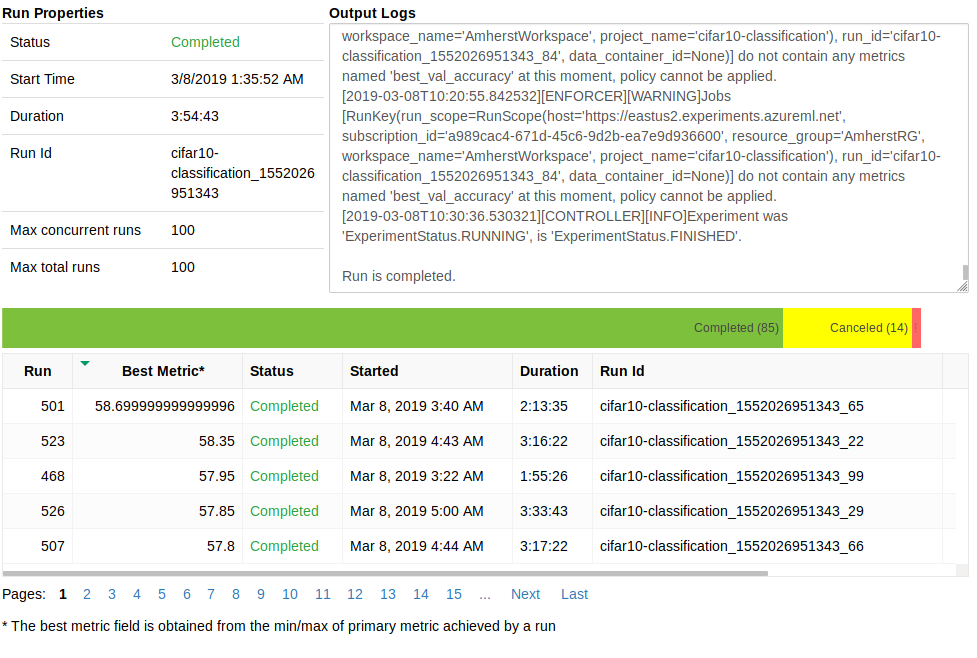

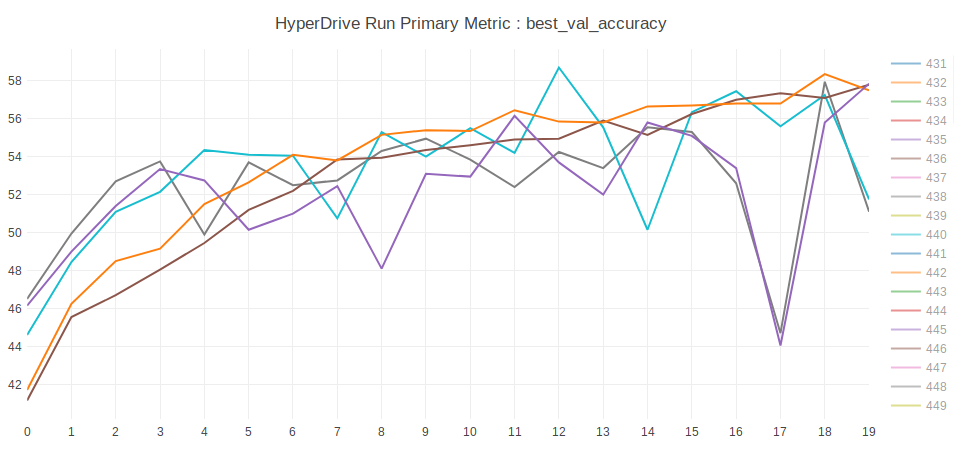

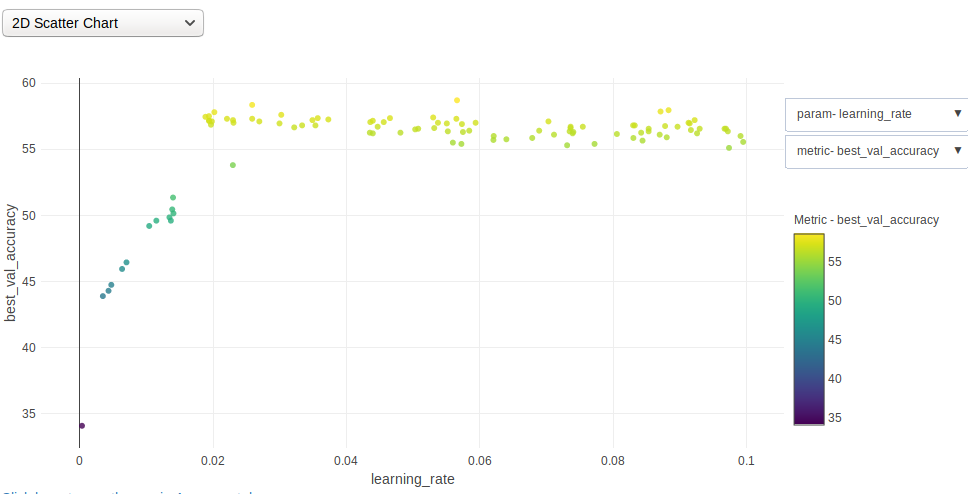

The best model achieved an accuracy of ~58% after optimizing the hyperparameters. Instead of manually performing trial and error of hyperparameter values, we were able to achieve the same with much less effort using the automated hyperparameter feature described here.

We can see that our termination policy led to 14 jobs being cancelled and a total of 85 runs to get the best values. We simply get the run which performed the best while comparing the primary metric. Once we have the run, we can display its metrics just like any other run of the experiment along with the best hyper-parameters found using the code below.  

In [31]:
warnings.simplefilter('ignore')
best_run = hyperdrive_run.get_best_run_by_primary_metric()
best_run_metrics = best_run.get_metrics()
parameter_values = best_run.get_details()['runDefinition']['Arguments']
print('Best Run Id: ', best_run.id)
print('Validation Accuracy:', max(best_run_metrics['best_val_accuracy']))
print('learning rate:',parameter_values[3])

Best Run Id:  cifar10-classification_1552026951343_65
Validation Accuracy: 58.699999999999996
learning rate: 0.0565822211810303


### Performing hyperparameter sweep with different set of choices

We can now use the best hyperparameter that we obtained in our previous step. In our model, we had arbitrarily fixed the hidden layer size. We now treat that as a hyperparameter and use a different strategy to perform another hyperparameter sweep. 

We add the *learning_rate* parameter to our script as a parameter and make the change in our script so that *hidden_size* becomes the hyperparameter to be optimized with a fixed *learning_rate* value. 

In [23]:
script_params = {
    '--data-folder': ds.as_mount(),
    '--learning_rate': 0.0565822211810303

}

pt_est = PyTorch(source_directory='./your_code',
                 script_params=script_params,
                 compute_target=compute_target,
                 entry_script='2layerfcnet.py',
                 use_gpu=True)

### Adopting a Grid Sampling Strategy

After initializing the estimator to be run for the hyperparameter sweep task, we specify the sampling strategy. For this step, we use the GridParameterSampling which performs a simple grid search over all the feasible values in the defined search space. Our hyperparameter is specified to be a choice amongst a list of values as this time we have discrete values to choose from. 

We use the same termination policy to be used by the HyperDriveRunConfig class to optimize the specified primary metric. We specify the goal to MAXIMIZE this metric. We end the policy after 100 runs by specifying the max_total_runs argument to the HyperDriveRunConfig class. We may also have specified *max_duration_minutes* to specify the maximum duration for which we want to run the experiment. In such a scenario, all runs would be automatically canceled after the elapsed time. 

In [24]:
from azureml.train.hyperdrive import GridParameterSampling,choice
param_sampling_2 = GridParameterSampling( {
        "hidden_size": choice(4000,5000,6000,7000,8000),
    }
)

from azureml.train.hyperdrive import HyperDriveRunConfig,PrimaryMetricGoal
hyperdrive_run_config_2 = HyperDriveRunConfig(estimator=pt_est,
                                           hyperparameter_sampling=param_sampling_2,
                                           policy=early_termination_policy,
                                           primary_metric_name="best_val_accuracy",
                                           primary_metric_goal=PrimaryMetricGoal.MAXIMIZE,
                                           max_total_runs=100)

## Submit the job

We submit the new hyperdrive run. 

In [26]:
hyperdrive_run_2 = exp.submit(hyperdrive_run_config_2)

## Visualizing the submitted job

We can follow the same steps to see the performance of this hyperdrive run. 

In [ ]:
warnings.simplefilter('ignore')
run_id = 'cifar10-classification_1553102764492' #Again we get this from the portal
run = Run(exp, run_id)
RunDetails(run).show()

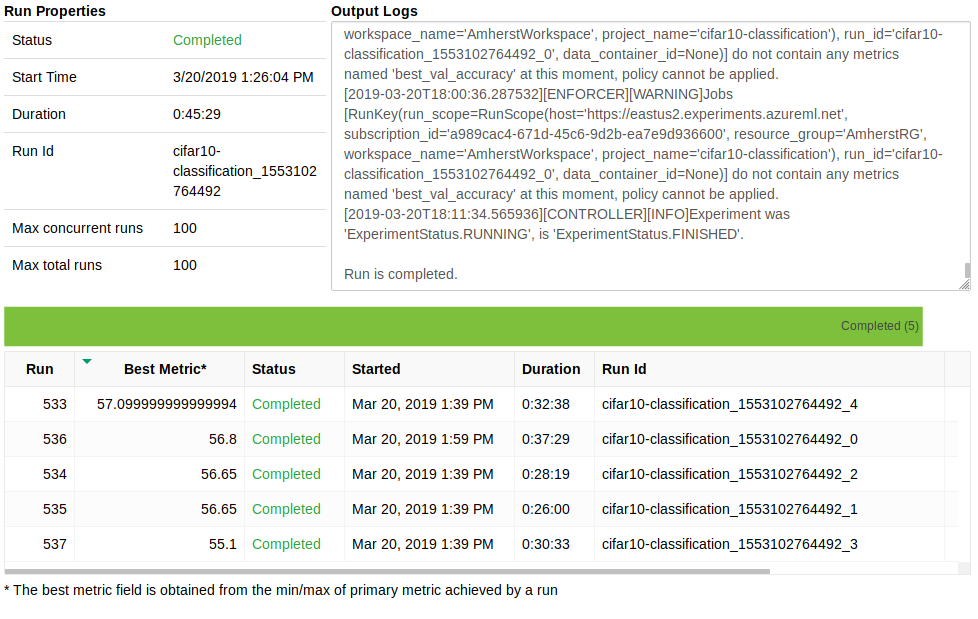

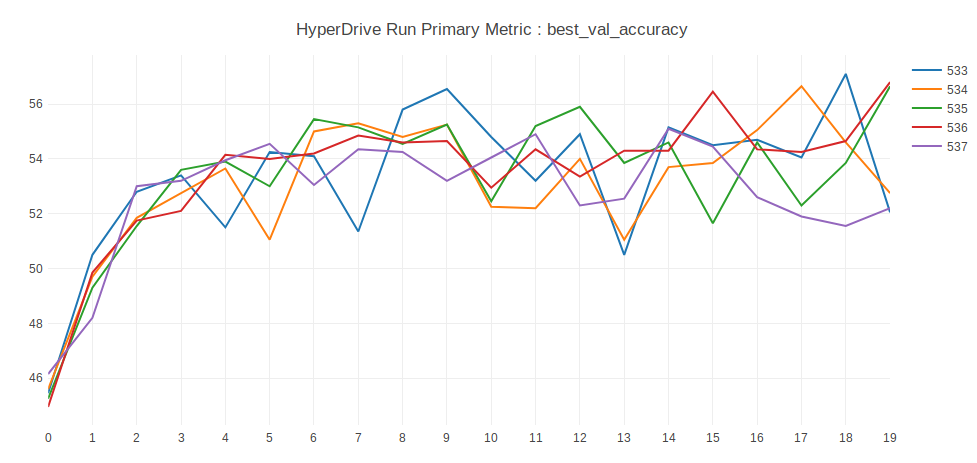

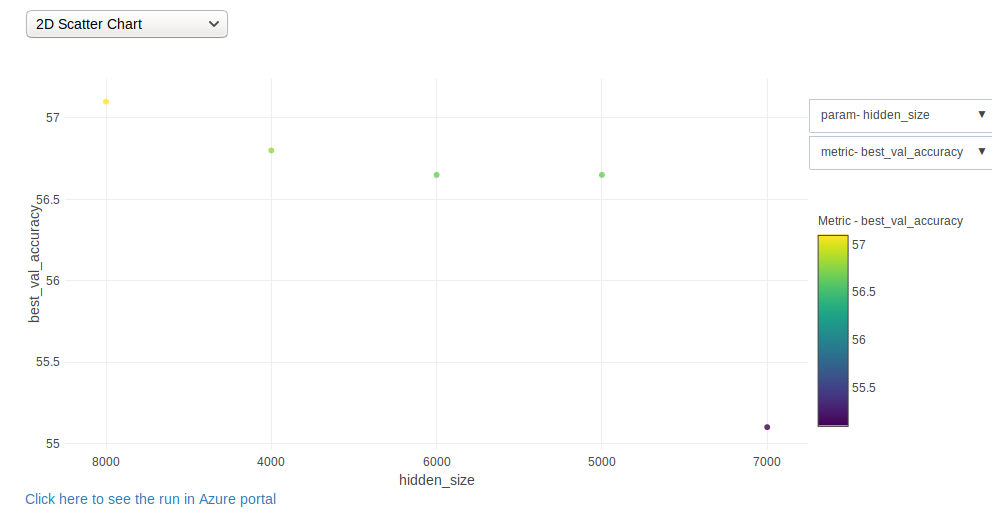

## Combining it together

In most situations, we don't have the patience to go through each of the hypeparameter values one by one. Instead of doing that, we can simply put all the hyperparameters that are to be optimized at one place, specify the search space for each of the hyperparameters, define the distribution from which the parameter is to be sampled and then, provide this as input to the HyperDriveRunConfig class. 

We demonstrate below the same using the same Estimator and *script_params* dictionary from before while modifying the sampling strategy. We use the Bayesian sampling approach which is facilitated by the BayesianParameterSampling class. It is based on Bayesian optimization algorithm and supports the *uniform* and *choice* distributions over the search space. One important point here is that this sampling doesn't support any early termination policy and hence, we set the *policy* parameter to None. We keep the other parameters as it is. 

In [35]:
script_params = {
    '--data-folder': ds.as_mount(),
}

pt_est = PyTorch(source_directory='./your_code',
                 script_params=script_params,
                 compute_target=compute_target,
                 entry_script='2layerfcnet.py',
                 use_gpu=True)

from azureml.train.hyperdrive import BayesianParameterSampling,uniform,choice

third_param_sampling = BayesianParameterSampling({
    "learning_rate":uniform(0.0001, 0.1),
    "hidden_size": choice(4000,5000,6000,7000,8000),
})

from azureml.train.hyperdrive import HyperDriveRunConfig,PrimaryMetricGoal
third_hyperdrive_run_config = HyperDriveRunConfig(estimator=pt_est,
                                           hyperparameter_sampling=third_param_sampling,
                                           policy=None,
                                           primary_metric_name="best_val_accuracy",
                                           primary_metric_goal=PrimaryMetricGoal.MAXIMIZE,
                                           max_total_runs=100)

### Submit the job

We submit this job to the portal.

In [38]:
third_hyperdrive_run = exp.submit(third_hyperdrive_run_config)

### Visualizing the submission

In [ ]:
run_id = 'cifar10-classification_1555046004015'
run = Run(exp, run_id)
RunDetails(run).show()

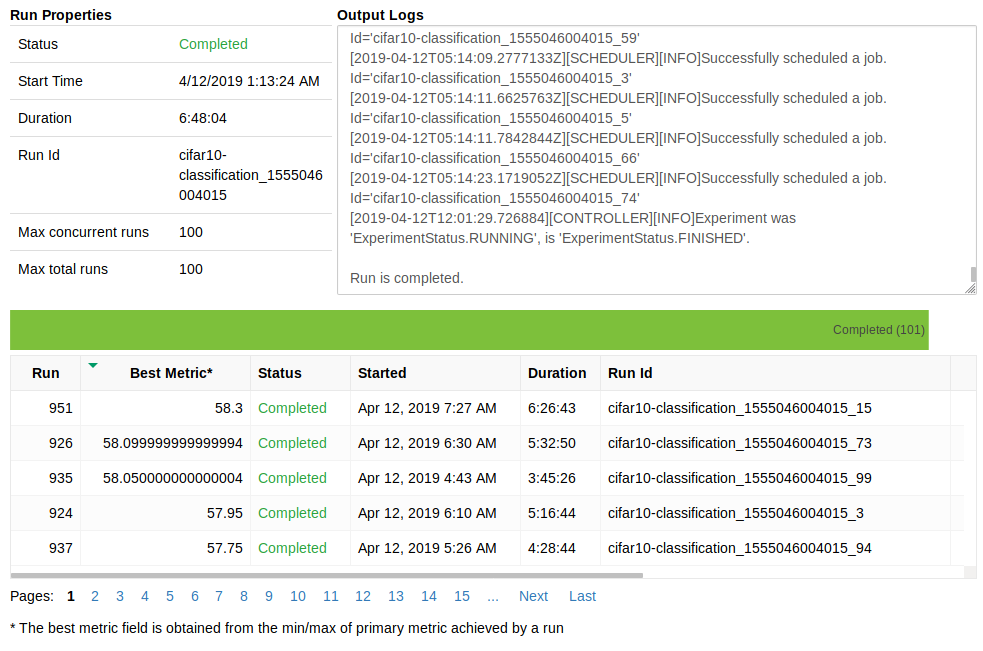

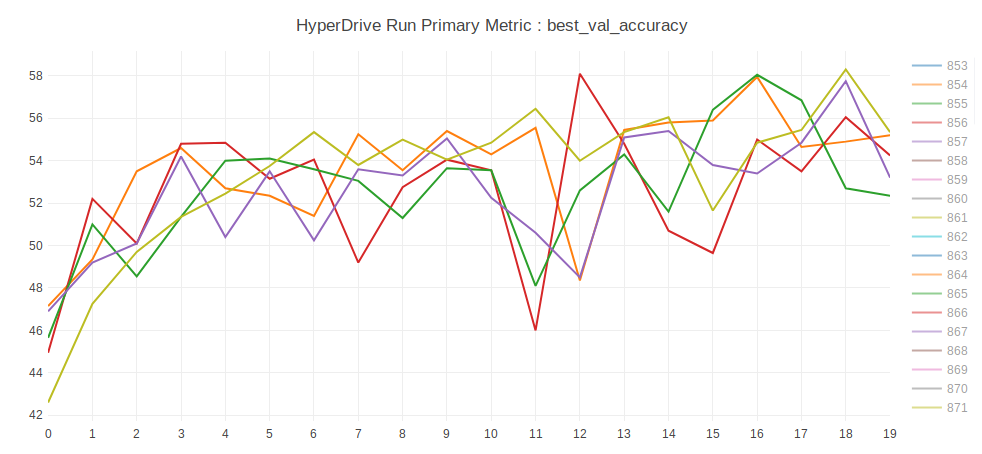

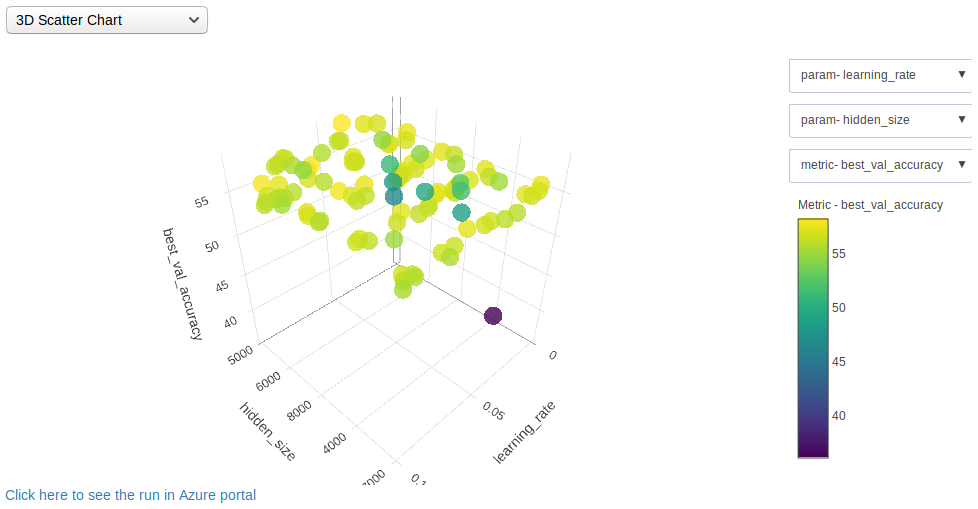

We display the 3D Scatter Chart instead of the 2D one for this run. From the chart, we can observe that the best performing model has 5000 hidden layers and uses a learning_rate of 0.03774594. 

### Cancel a run

We can get the run instance using the *get_run* module with the experiment and run ID. We can then use this instance to cancel a given run during its execution. The code used for the same is provided below - 

In [ ]:
'''
from azureml.core import get_run                                                                                                            run_id = 'cifar10-classification_1554952345176_1'
run=get_run(exp, run_cpu_id)
run.cancel()
'''

## Results <a class="anchor" id="results"></a>

We started off with a baseline model which achieved ~42% accuracy on the validation set. We then walked through the hyperparameter sweep functionality available to utilize its advantages. Initially, we tuned for *learning_rate* hyperparameter which led to a big performance improvement. We then performed another tuning for *hidden_size* model parameter. At the end, we combined those two to obtain an accuracy of ~58%.   

### Register the best model

We end this tutorial by registerting the best model we obtained. This will help us or other collaborators query, examine and deploy this model at a later time. 

In [ ]:
model = run.register_model(model_name='cifar_fcnet', model_path='outputs/cifar_fcnet_model.pkl')
print(model.name, model.id, model.version, sep = '\t')